### Curve Shortening Flow
The aim of this notebook is to demonstrate the curve shortening flow for 1 dimensional graphs, and perhaps for planar curves. 

A javascript version of such an approximation partly inspired me to try implement such an approximation in Python, this can be found at https://github.com/acarapetis/curve-shortening-demo

The curve shortening flow is the 1-dimensional version of mean curvature flow. It is the evolution of a curve in the direction of it's curvature vector. In detail, let $\gamma : [0,1] \rightarrow \mathbb{R}^2$ be a curve (typically at least Lipschitz continuous). Writing $\gamma(t) = (x(t), y(t))$ we can write the (signed) curvature as the following local expression.

$$ \kappa = \frac{x' y'' - y' x''}{(x' ^2 + y' ^2)^\frac{3}{2}}$$

The curvature vector is then $\kappa \mathbf{n}$ where $\mathbf{n}$ is the normal vector. In $\mathbb{R}^2$ we have the following simple formula

$$ \mathbf{n} = \frac{1}{(x' ^2 + y' ^2)^\frac{1}{2}}(-y', x') $$

As such the curve shortening flow is a solution to the following partial differential equation, where $\gamma : [0,1] \times [0, T) \rightarrow \mathbb{R}^2$ is now a family of curves $\gamma(t,s) = \gamma_s (t)$.

$$ \frac{\partial \gamma_s}{\partial s} = \kappa_s \mathbf{n}_s. $$

#### Coding details
To approximate this flow we will use the standard technique of taking small discrete steps in time. 

A curve $\gamma : [0,1] \rightarrow \mathbf{R}^2$ is approximated linearly by taking a grid $0 = t_0 < t_1 < \ldots < t_{N-1} = 1$ for some large $N>0$, and using an array that stores the $\gamma(t_i)$ at index $i$. 

A derivative of $\gamma$ is approximated at these points $t_i$ by a symmetric finite difference (except at the boundaries) 

$$ \gamma'(t_i) \approx \frac{\gamma(t_{i+1}) - \gamma(t_{i-1})}{t_{i+1} - t_{i-1}} $$

Typically the grid of $t_i$ are equally spaced. Similarly we can approximate the second derivatives by finite differences. This can easily be implemented with np.roll or simply using the built-in np.gradient methods.

These approximations break down at points of high curvature which can cause the approximation of the flow to be poor near such points.

#### Graphs and closed curves
Typically one considers closed curves, that is $\gamma(0) = \gamma(1)$, or considering $\gamma$ as a map on $\mathbb{R} / \mathbb{Z}$. These turn out to be slightly more difficult to approximate due to the points $\gamma(1-\epsilon)$ for small $\epsilon$, and further because under curve shortening flow a closed embedded curve always shrinks to a round point (an infinitessimally small circle) and as such the curvatures get very large. 

As such I thought it was best to first implement the simple case of the evolution for a graph, that is $\gamma(t) = (t, y(t))$, treating $\gamma(0)$ and $\gamma(1)$ as fixed boundary points. The evolution in this case is not particularly interesting, the curve evolves by smoothing out any points of high curvature and eventually becoming the straight line between $\gamma(0)$ and $\gamma(1)$. Nevertheless this suffices to demonstrate the flow, demonstrate how a Lipschitz continuous curve becomes immediately smooth under the flow, and even a simple version of the comparison principle, that two initially disjoint curvature flows will remain disjoint throughout the evolution.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

#### Graph case
In this case we simply approximate $y$ by a two-dimensional array $\texttt{y}$ where 

$$ \texttt{y[i,j]} == y(x_i, t_j)$$

and $x_i, t_j$ are grids over $[0,1]$ and $[0,T)$ for some final time $T$. We need an initial function $f$ such that 

$$ \texttt{y[:,0]} = f(\texttt{x[:,0]})$$

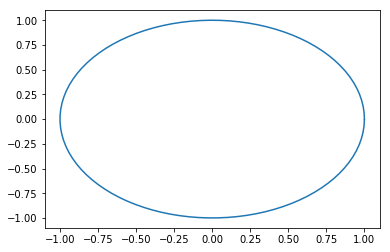

In [211]:
def initialise_graph(f,x_left_boundary = 0, x_right_boundary = 1,
                     space_steps = 200, time_steps = 1000):
    # initialise arrays
    x = np.zeros((space_steps, time_steps))
    y = np.zeros((space_steps, time_steps))
    # initial values
    x[:,0] = np.linspace(x_left_boundary, x_right_boundary, space_steps)
    y[:,0] = f(x[:,0])
    return x,y

def initialise_curve(fx = np.cos, fy = np.sin, space_steps = 200, time_steps = 1000):
    t = np.linspace(0,2*np.pi-0.01, space_steps)
    x = np.zeros((space_steps,time_steps))
    y = np.zeros((space_steps,time_steps))
    x[:,0] = fx(t)
    y[:,0] = fy(t)
    return x,y

def f(x):
    return np.abs(x-0.5)

# sine-wave example
space_steps = 100
x,y = initialise_curve(space_steps = space_steps)
plt.plot(x[:,0], y[:,0])
plt.show()

0.0
0.0


Note that when we compute gradients of $\texttt{y[i,j]}$ we get

$$\frac{\texttt{y[i+1,0]-y[i-1,0]}}{t_{i+1} - t_{i-1}} \approx y'(t_i)x'(t_i)$$

As such we need to divide np.gradient(y) by np.gradient(x) to get $y'$. Similarly this is true for the approximation to $y''$.

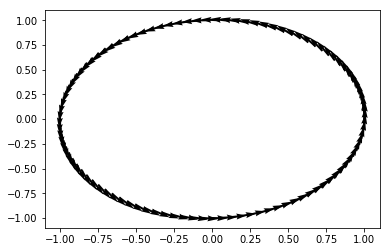

In [212]:
# approximate normal and curvatures
# note here x,y are thought to be a single time slice e.g. x[:,0]
def approximate_tangent(x,y):
    dx = grad(x)
    dy = grad(y)
    normalisation = np.sqrt(np.power(dx,2)+np.power(dy,2))
    return dx/normalisation, dy/normalisation

tx, ty = approximate_tangent(x[:,0], y[:,0])
plt.quiver(x[:,0], y[:,0], tx,ty)
plt.show()

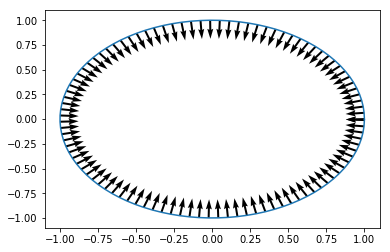

In [213]:
def approximate_normal(x,y):
    tx,ty = approximate_tangent(x,y)
    return -ty, tx
nx,ny = approximate_normal(x[:,0], y[:,0])
plt.quiver(x[:,0],y[:,0], nx,ny)
plt.plot(x[:,0], y[:,0])
plt.show()

Note that in the curvature vector plot below I have attempted to make the plot clearer by rescaling the curvature, and only plotting evrey 3rd point.

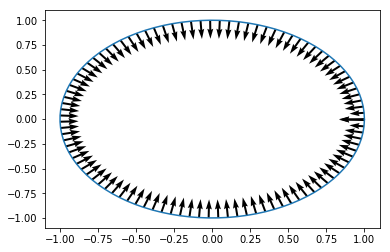

In [215]:
def grad(x):
    t = np.linspace(0, 2*np.pi-0.01, 100)
    dx = (np.roll(x,-1)-np.roll(x,1))/((np.roll(t,-1)-np.roll(t,1))%(2*np.pi))
    #dx[-1] = (x[0] - x[-2])/(t[0]+2*np.pi - t[-1]) 
    return dx

    
def approximate_curvature(x,y):
    dx = grad(x)
    dy = grad(y)
    ddx = grad(dx)
    ddy = grad(dy)
    kappa = (dx*ddy - ddx * dy)/np.power(np.power(dx,2)+np.power(dy,2),1.5)
    return kappa

k = approximate_curvature(x[:,0], y[:,0])



plt.quiver(x[:,0],y[:,0], k*nx, k*ny)
plt.plot(x[:,0], y[:,0])
plt.show()

Due to the approximation there seemed to be issues with the evolution, causing small ripple like disturbances near points of high curvature. 

To rectify this I have used a moving average smoothing to clear up some of this behaviour. However the effectiveness of this seems to depend on the step_size, and the number of space_steps (i.e. the resolution in samples of x).

Below are the definitions of this smoothing function and a step-wise evolution function. Below that I evolve the initial curve for a number of steps and plot every 15th curve.

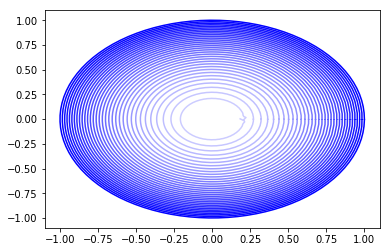

In [291]:
def ma_smooth(x, window_size = 2):
    for i in range(window_size, len(x)-window_size):
        smooth = x[i]
        for j in range(window_size):
            smooth += x[i-j]
            smooth += x[i+j]
        x[i] = smooth/(2*window_size + 1)



def evolve(x,y, step_size=1):
    # evolution
    nx, ny = approximate_normal(x,y)
    k = approximate_curvature(x,y)
    x_new = x + step_size*nx*k
    y_new = y + step_size*ny*k
    # smooth x,y
    ma_smooth(x_new,1)
    ma_smooth(y_new,1)
    return x_new, y_new


plt.plot(x[:,0],y[:,0], c='b', alpha = 1)
for i in range(1,961):
    x[:,i], y[:,i] = evolve(x[:,i-1], y[:,i-1], step_size=0.0004985)
    if i%30==0:
        plt.plot(x[:,i], y[:,i], c = 'b', alpha = 1-(i/1200))
plt.show()

We can animate this evolution using matplotlib's animation function, and using HTML to convert to a video.

In [292]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -1.1, 1.1))
ax.set_ylim((-1.1, 1.1))
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    line.set_data(x[:,i], y[:,i])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=960, interval=40, blit=True)
HTML(anim.to_html5_video())